<a href="https://colab.research.google.com/github/Philewj/CS-695-CNN-Implementation-MNIST/blob/main/CS_695_Lab1_Excercise_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Implementing CNN for the MNIST Dataset

## Building Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [ ]:
#Covert MNIST Image Files into Tensors of 4 Dimensions (# of images, Height, Width, Color Channels)
transform = transforms.ToTensor()
#Load Training Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)
#Load Testing Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [ ]:
#Verifying Training Data
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
#Verifying Testing Data
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Build Model

In [ ]:
#Model Class
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 Convolutional Layers
    self.convolution_layer1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3,stride=1)
    self.convolution_layer2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3,stride=1)

    #Fully Connected Neural Layers
    self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.dropout1 = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=120, out_features=85) # decrease the number of out features (can be an arbitrary number)
    self.dropout2 = nn.Dropout(0.25)
    self.fc3 = nn.Linear(in_features=85, out_features=55) # is the number of classes in the dataset
    self.dropout3 = nn.Dropout(0.25)
    self.fc4 = nn.Linear(in_features=55, out_features=10) # is the number of classes in the dataset

  def forward(self, X):
    # Pass through Convolutional Layer 1
    X = F.relu(self.convolution_layer1(X))
    X = F.max_pool2d(X, 2, 2)
    # Pass through Convolutional Layer 2
    X = F.relu(self.convolution_layer2(X))
    X = F.max_pool2d(X, 2, 2)

    #Re-View data to flatten it out
    X = X.view(-1, 16*5*5) # -1 so we can vary batch size

    #Pass through the Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = self.dropout1(X)
    X = F.relu(self.fc2(X))
    X = self.dropout2(X)
    X = F.relu(self.fc3(X))
    X = self.dropout3(X)
    X = self.fc4(X)
    return F.log_softmax(X, dim=1)

In [ ]:
#Create an Intance of the Model
#Create a manual seed
torch.manual_seed(34)
model = ConvolutionalNeuralNetwork()
model

ConvolutionalNeuralNetwork(
  (convolution_layer1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (convolution_layer2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=120, out_features=85, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=85, out_features=55, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=55, out_features=10, bias=True)
)

In [ ]:
#Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training and Validation Accuracy/Loss

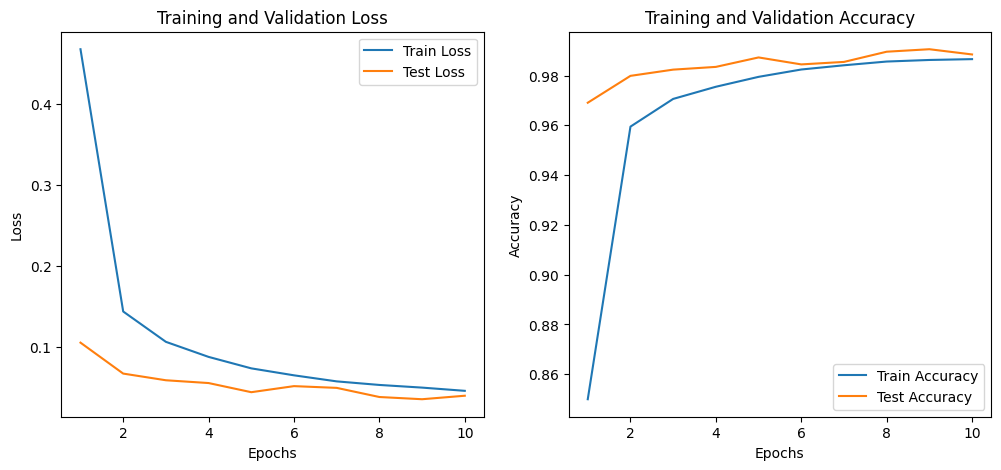

In [ ]:

# Function to train and log accuracy/loss
def train_and_log(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        # Evaluate on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                outputs = model(X_test)
                loss = criterion(outputs, y_test)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_test).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / len(test_loader.dataset))

    return train_losses, test_losses, train_accuracies, test_accuracies

# Plotting function
def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, test_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.show()

# Example usage
model = ConvolutionalNeuralNetwork()#(dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

train_losses, test_losses, train_accuracies, test_accuracies = train_and_log(
    model, train_loader, test_loader, optimizer, criterion, epochs=10
)

# Plot the curves
plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)


In [ ]:
for i in range(10):
  #print(train_accuracies[i])
  print(f"Epoch {i+1} : Accuracy : {test_accuracies[i] * 100:.2f}%")

Epoch 1 : Accuracy : 96.91%
Epoch 2 : Accuracy : 97.99%
Epoch 3 : Accuracy : 98.24%
Epoch 4 : Accuracy : 98.35%
Epoch 5 : Accuracy : 98.73%
Epoch 6 : Accuracy : 98.45%
Epoch 7 : Accuracy : 98.55%
Epoch 8 : Accuracy : 98.96%
Epoch 9 : Accuracy : 99.06%
Epoch 10 : Accuracy : 98.85%


### Visualizing Filters and Feature Maps

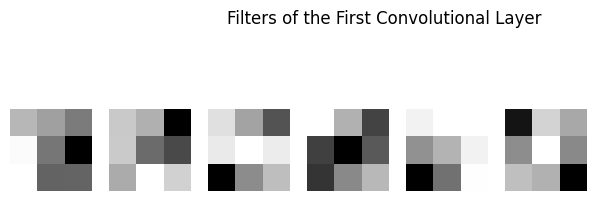

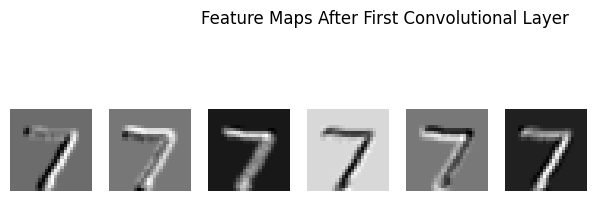

In [ ]:

# Visualizing filters of the first convolutional layer
def visualize_filters(model):
    # Access the weights of the first convolutional layer
    conv1_weights = model.convolution_layer1.weight.data.cpu()
    num_filters = conv1_weights.shape[0]  # Number of filters

    plt.figure(figsize=(10, 10))
    for i in range(num_filters):
        plt.subplot(8, 8, i + 1)  # Adjust grid size based on the number of filters
        plt.imshow(conv1_weights[i, 0, :, :], cmap="gray")
        plt.axis("off")
    plt.suptitle("Filters of the First Convolutional Layer")
    plt.show()

# Visualizing feature maps for an input image
def visualize_feature_maps(model, image):
    with torch.no_grad():
        # Pass the image through the first convolutional layer
        conv1_output = model.convolution_layer1(image.unsqueeze(0))

    # Convert feature maps to numpy for visualization
    feature_maps = conv1_output.squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(feature_maps.shape[0]):
        plt.subplot(8, 8, i + 1)  # Adjust grid size
        plt.imshow(feature_maps[i, :, :], cmap="gray")
        plt.axis("off")
    plt.suptitle("Feature Maps After First Convolutional Layer")
    plt.show()

# Visualize filters and feature maps
visualize_filters(model)
image = test_data[0][0]  # Use the first test image
visualize_feature_maps(model, image)


### Hyperparameter Analysis

In [ ]:

import time
# Function to train the model with different hyperparameters
def train_with_hyperparameters(learning_rates, dropout_rates, batch_sizes):
    results = []  # To store results for each configuration

    for lr in learning_rates:
        for dropout in dropout_rates:
            for batch_size in batch_sizes:
                print(f"Training with LR={lr}, Dropout={dropout}, Batch Size={batch_size}")

                # Define the model with the given dropout
                #model = ConvolutionalNeuralNetwork(dropout=dropout)
                model = ConvolutionalNeuralNetwork()
                model.dropout1 = nn.Dropout(dropout)
                model.dropout2 = nn.Dropout(dropout)
                model.dropout3 = nn.Dropout(dropout)
                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # DataLoader with the given batch size
                train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

                # Training loop
                start_time = time.time()
                model.train()
                for epoch in range(5):  # Train for 5 epochs
                    running_loss = 0.0
                    for X_batch, y_batch in train_loader:
                        optimizer.zero_grad()
                        outputs = model(X_batch)
                        loss = criterion(outputs, y_batch)
                        loss.backward()
                        optimizer.step()
                        running_loss += loss.item()

                # Evaluate on test set
                model.eval()
                correct = 0
                with torch.no_grad():
                    for X_test, y_test in test_loader:
                        outputs = model(X_test)
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == y_test).sum().item()

                accuracy = correct / len(test_data)
                training_time = time.time() - start_time

                # Save results
                results.append({
                    "Learning Rate": lr,
                    "Dropout": dropout,
                    "Batch Size": batch_size,
                    "Accuracy": accuracy,
                    "Training Time (s)": training_time
                })
                print(f"Accuracy: {accuracy:.4f}, Time: {training_time:.2f}s")

    return results

# Example hyperparameters
learning_rates = [0.001, 0.01]
dropout_rates = [0.2, 0.5]
batch_sizes = [64, 128]

# Run the experiments
results = train_with_hyperparameters(learning_rates, dropout_rates, batch_sizes)

# Visualize the results
results_df = pd.DataFrame(results)
print(results_df)


Training with LR=0.001, Dropout=0.2, Batch Size=64
Accuracy: 0.9843, Time: 77.02s
Training with LR=0.001, Dropout=0.2, Batch Size=128
Accuracy: 0.9845, Time: 67.33s
Training with LR=0.001, Dropout=0.5, Batch Size=64
Accuracy: 0.9830, Time: 75.00s
Training with LR=0.001, Dropout=0.5, Batch Size=128
Accuracy: 0.9812, Time: 64.83s
Training with LR=0.01, Dropout=0.2, Batch Size=64
Accuracy: 0.9780, Time: 74.14s
Training with LR=0.01, Dropout=0.2, Batch Size=128
Accuracy: 0.9843, Time: 64.71s
Training with LR=0.01, Dropout=0.5, Batch Size=64
Accuracy: 0.9264, Time: 75.86s
Training with LR=0.01, Dropout=0.5, Batch Size=128
Accuracy: 0.9663, Time: 64.27s
   Learning Rate  Dropout  Batch Size  Accuracy  Training Time (s)
0          0.001      0.2          64    0.9843          77.022610
1          0.001      0.2         128    0.9845          67.327291
2          0.001      0.5          64    0.9830          74.999155
3          0.001      0.5         128    0.9812          64.833955
4        

### Adversarial Attacks

In [ ]:
#Download torchattacks library
!pip install torchattacks

In [ ]:
#Import torchattacks library for Adversarial Attacks
import torchattacks

In [ ]:
# Define device for computation (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ConvolutionalNeuralNetwork(
  (convolution_layer1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (convolution_layer2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=120, out_features=85, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=85, out_features=55, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=55, out_features=10, bias=True)
)

#### Fast Gradient Sign Method (FGSM)

In [ ]:
# Define FGSM attack with a default epsilon value
epsilon = 0.1
fgsm_attack = torchattacks.FGSM(model, eps=epsilon)

# Generate adversarial examples
def generate_fgsm_adversarial_examples(model, data_loader, attack):
    adv_examples = []
    model.eval()

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)
        adv_examples.append((images.cpu(), adv_images.cpu(), labels.cpu()))

    return adv_examples

# Generate adversarial examples from the test set
adv_examples = generate_fgsm_adversarial_examples(model, test_loader, fgsm_attack)


In [ ]:
# Evaluate model performance on FGSM adversarial examples
adv_data_accuracy = []
def evaluate_model_on_adversarial_data(model, adv_examples):
    correct = 0
    total = 0

    model.eval()
    for original, adversarial, target in adv_examples:
        adversarial = adversarial.to(device)
        target = target.to(device)

        output = model(adversarial)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    accuracy = correct / total
    adv_data_accuracy.append(accuracy)
    print(f"Model Accuracy on Adversarial Data: {accuracy * 100:.2f}%")

# Evaluate the model on adversarial examples
evaluate_model_on_adversarial_data(model, adv_examples)

Model Accuracy on Adversarial Data: 88.50%


In [ ]:
clean_data_accuracy = test_accuracies[9]
adv_data_accuracy = adv_data_accuracy[0]

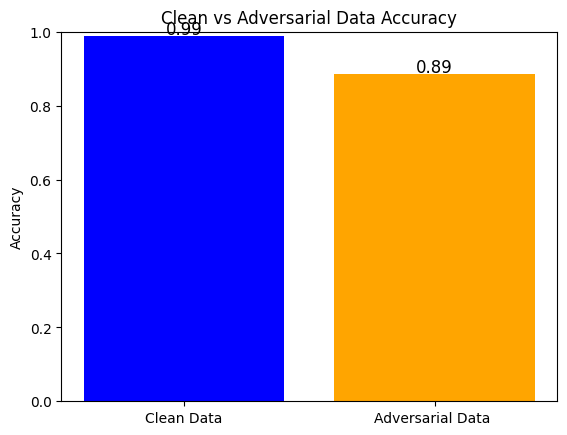

In [ ]:
# Compare Clean Data and Adversarial Data Accuracy
categories = ['Clean Data', 'Adversarial Data ']
values = [clean_data_accuracy, adv_data_accuracy]

# Plot the bar chart
plt.bar(categories, values, color=['blue', 'orange'])

# Add labels and title
plt.ylabel('Accuracy')
plt.title('Clean vs Adversarial Data Accuracy')

# Display values on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontsize=12)

# Show the plot
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for better visualization
plt.show()

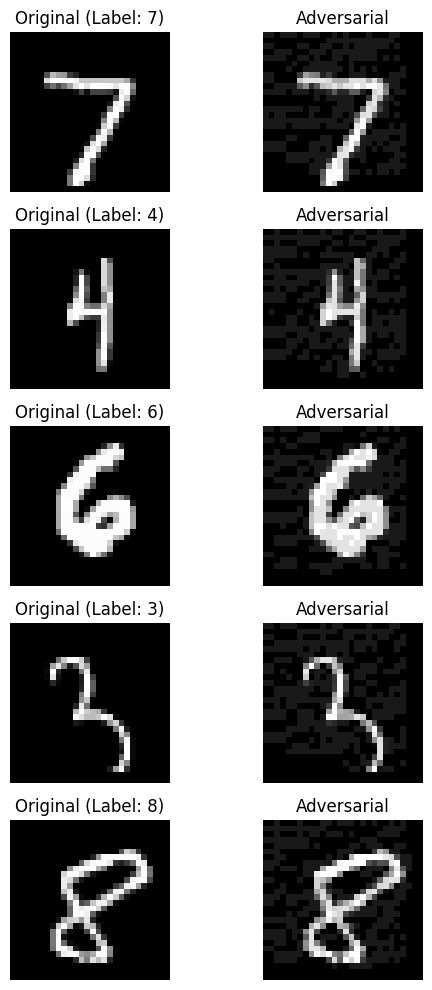

In [ ]:
# Visualization of original vs. adversarial images

def visualize_adversarial_examples(adv_examples, num_samples=5):
    """
    Plots original vs. adversarial images side by side.
    """
    fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(6, num_samples * 2))

    for i, (original, adversarial, target) in enumerate(adv_examples[:num_samples]):
        # Convert tensors to numpy and squeeze batch dimension
        original_np = original[i].squeeze().cpu().numpy()
        adversarial_np = adversarial[i].squeeze().detach().cpu().numpy()

        # Plot original image
        axes[i, 0].imshow(original_np, cmap="gray")
        axes[i, 0].set_title(f"Original (Label: {target[i].item()})")
        axes[i, 0].axis("off")

        # Plot adversarial image
        axes[i, 1].imshow(adversarial_np, cmap="gray")
        axes[i, 1].set_title("Adversarial")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the fixed adversarial examples
visualize_adversarial_examples(adv_examples)



Testing with epsilon = 0.05
Model Accuracy on Adversarial Data: 95.46%
Testing with epsilon = 0.1
Model Accuracy on Adversarial Data: 88.50%
Testing with epsilon = 0.2
Model Accuracy on Adversarial Data: 61.96%
Testing with epsilon = 0.3
Model Accuracy on Adversarial Data: 27.82%


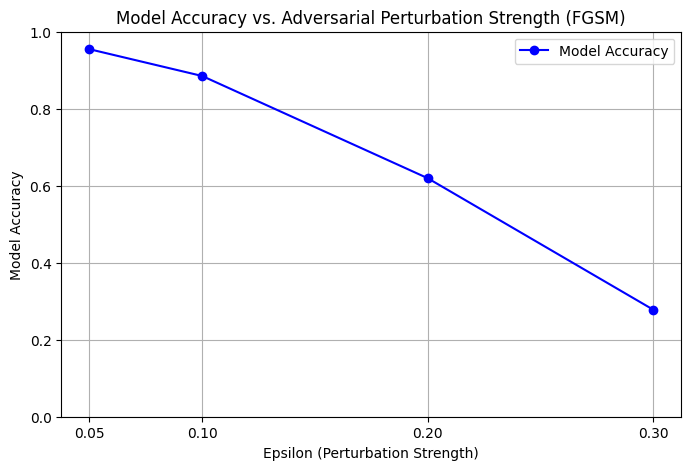

In [ ]:
# Define epsilon values used in experiments
epsilons = [0.05, 0.1, 0.2, 0.3]

# Store accuracy results for each epsilon
accuracies = []

# Run evaluation for different epsilon values
for eps in epsilons:
    print(f"Testing with epsilon = {eps}")
    fgsm_attack = torchattacks.FGSM(model, eps=eps)
    adv_examples = generate_fgsm_adversarial_examples(model, test_loader, fgsm_attack)

    # Evaluate model on adversarial examples
    correct = 0
    total = 0
    model.eval()

    for original, adversarial, target in adv_examples:
        adversarial = adversarial.to(device)
        target = target.to(device)

        output = model(adversarial)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Model Accuracy on Adversarial Data: {accuracy * 100:.2f}%")

# Plot the accuracy results
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accuracies, marker='o', linestyle='-', color='b', label="Model Accuracy")
plt.xlabel("Epsilon (Perturbation Strength)")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy vs. Adversarial Perturbation Strength (FGSM)")
plt.xticks(epsilons)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(accuracies)

[0.9546, 0.885, 0.6196, 0.2782]


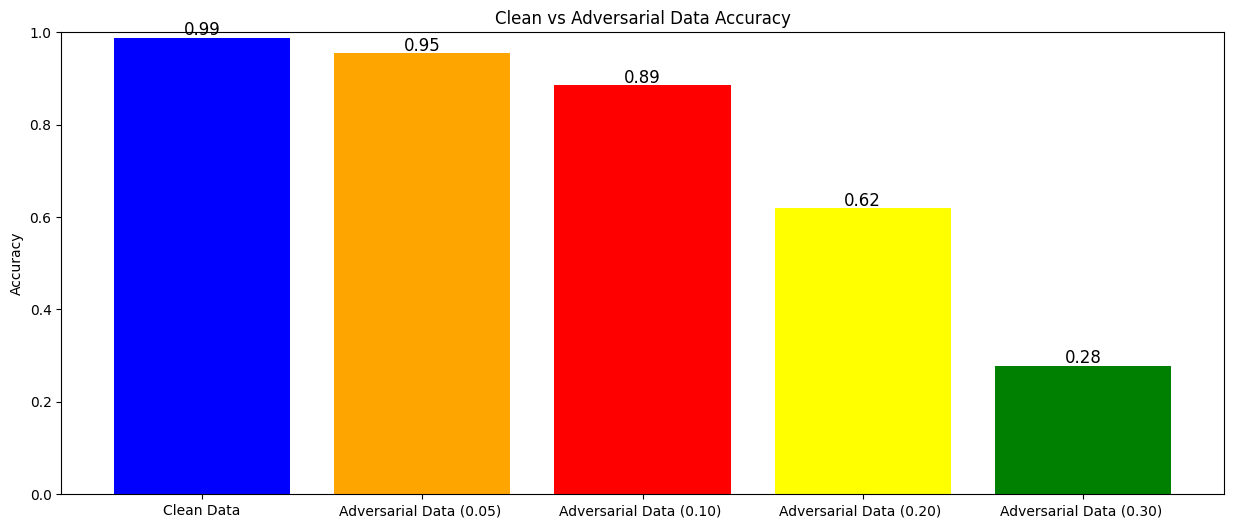

In [ ]:
# Compare Clean Data and Adversarial Data Accuracy
categories = ['Clean Data', 'Adversarial Data (0.05) ','Adversarial Data (0.10) ','Adversarial Data (0.20) ', 'Adversarial Data (0.30) ' ]
values = [clean_data_accuracy, accuracies[0],accuracies[1], accuracies[2], accuracies[3]]

# Plot the bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, values, color=['blue', 'orange', 'red', 'yellow', 'green'])

# Add labels and title
plt.ylabel('Accuracy')
plt.title('Clean vs Adversarial Data Accuracy')

# Display values on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontsize=12)

# Show the plot
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for better visualization
plt.show()

#### Projected Gradient Descent (PGD)

In [ ]:
# Define PGD attack
pgd_attack = torchattacks.PGD(model, eps=0.1, alpha=0.01, steps=40)

# Generate adversarial examples using PGD
def generate_pgd_adversarial_examples(model, data_loader, attack):
    adv_examples = []
    model.eval()

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)
        adv_examples.append((images.cpu(), adv_images.cpu(), labels.cpu()))

    return adv_examples

# Generate adversarial examples from the test set using PGD
adv_examples_pgd = generate_pgd_adversarial_examples(model, test_loader, pgd_attack)


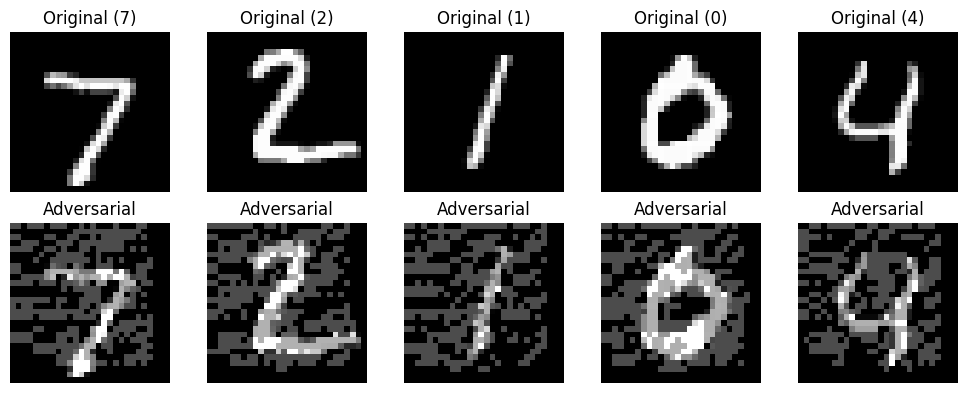

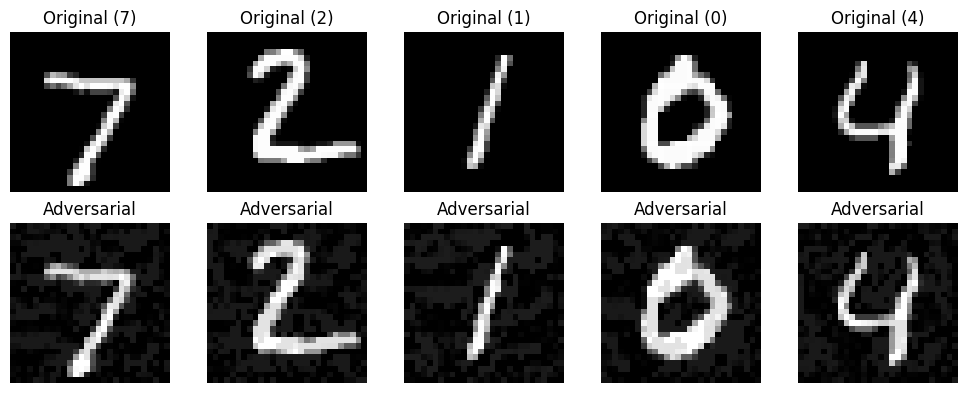

In [ ]:
def plot_adversarial_examples(original, adversarial, labels, num_examples=5):
    fig, axes = plt.subplots(2, num_examples, figsize=(10, 4))

    for i in range(num_examples):
        orig_img = original[i].squeeze().cpu().numpy()
        adv_img = adversarial[i].squeeze().cpu().numpy()
        label = labels[i].item()

        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].set_title(f"Original ({label})")
        axes[0, i].axis('off')

        axes[1, i].imshow(adv_img, cmap='gray')
        axes[1, i].set_title("Adversarial")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Select examples from FGSM and PGD attacks
original_images = [ex[0] for ex in adv_examples[:5]]  # Extract original images
adv_images_fgsm = [ex[1] for ex in adv_examples[:5]]  # Extract FGSM adversarial images
adv_images_pgd = [ex[1] for ex in adv_examples_pgd[:5]]  # Extract PGD adversarial images
labels = [ex[2] for ex in adv_examples[:5]]  # Extract labels

# Convert list of tensors to a tensor batch for consistent indexing
original_images = torch.cat(original_images, dim=0)
adv_images_fgsm = torch.cat(adv_images_fgsm, dim=0)
adv_images_pgd = torch.cat(adv_images_pgd, dim=0)
labels = torch.cat(labels, dim=0)

# Plot FGSM adversarial examples
plot_adversarial_examples(original_images, adv_images_fgsm, labels)

# Plot PGD adversarial examples
plot_adversarial_examples(original_images, adv_images_pgd, labels)

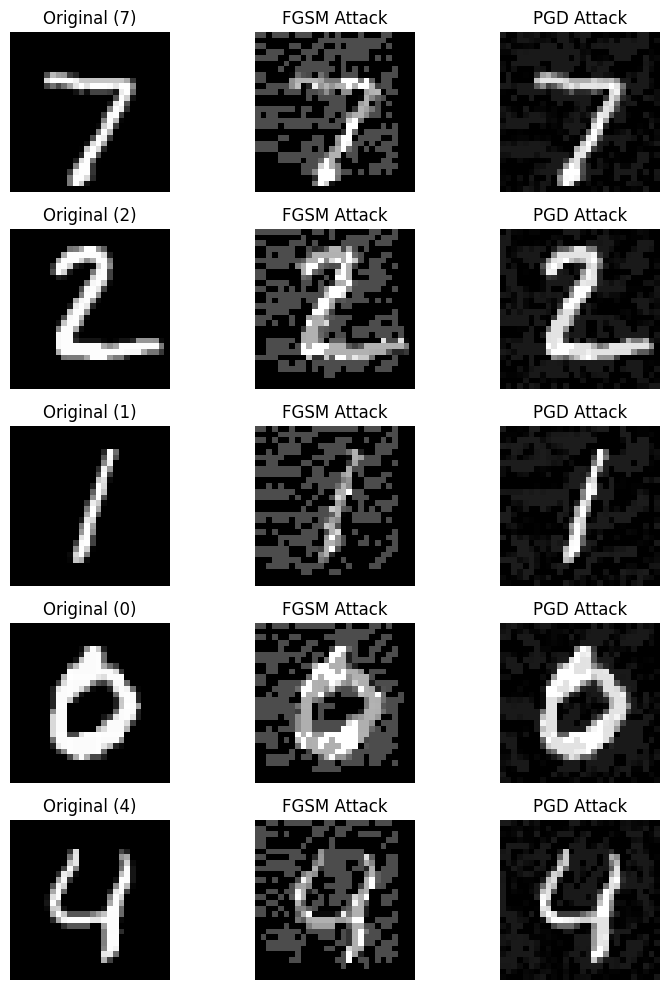

In [ ]:
def plot_adversarial_comparison(original, adv_fgsm, adv_pgd, labels, num_examples=5):
    fig, axes = plt.subplots(num_examples, 3, figsize=(8, 10))

    for i in range(num_examples):
        orig_img = original[i].squeeze().cpu().numpy()
        fgsm_img = adv_fgsm[i].squeeze().cpu().numpy()
        pgd_img = adv_pgd[i].squeeze().cpu().numpy()
        label = labels[i].item()

        axes[i, 0].imshow(orig_img, cmap='gray')
        axes[i, 0].set_title(f"Original ({label})")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(fgsm_img, cmap='gray')
        axes[i, 1].set_title("FGSM Attack")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pgd_img, cmap='gray')
        axes[i, 2].set_title("PGD Attack")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Select examples from FGSM and PGD attacks
original_images = [ex[0] for ex in adv_examples[:5]]  # Extract original images
adv_images_fgsm = [ex[1] for ex in adv_examples[:5]]  # Extract FGSM adversarial images
adv_images_pgd = [ex[1] for ex in adv_examples_pgd[:5]]  # Extract PGD adversarial images
labels = [ex[2] for ex in adv_examples[:5]]  # Extract labels

# Convert list of tensors to a tensor batch for consistent indexing
original_images = torch.cat(original_images, dim=0)
adv_images_fgsm = torch.cat(adv_images_fgsm, dim=0)
adv_images_pgd = torch.cat(adv_images_pgd, dim=0)
labels = torch.cat(labels, dim=0)

# Plot comparison with columns: Original | FGSM | PGD
plot_adversarial_comparison(original_images, adv_images_fgsm, adv_images_pgd, labels)

In [ ]:
def evaluate_adversarial_accuracy(model, data_loader, attack, device):
    """
    Evaluates model accuracy on adversarial examples generated using the given attack method.

    Parameters:
        model (torch.nn.Module): Trained CNN model.
        data_loader (torch.utils.data.DataLoader): Test data loader.
        attack (torchattacks.attack): Adversarial attack (e.g., PGD, FGSM).
        device (torch.device): Device to run the evaluation on.

    Returns:
        float: Adversarial accuracy.
    """
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        # Enable gradient tracking for adversarial attack
        images.requires_grad = True

        # Generate adversarial examples
        adv_images = attack(images, labels)

        # Get model predictions
        outputs = model(adv_images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return correct / total  # Return accuracy as a fraction

In [ ]:
pgd_accuracy = evaluate_adversarial_accuracy(model, test_loader, pgd_attack, device)

print(f"Model accuracy on PGD adversarial examples: {pgd_accuracy * 100:.2f}%")

Model accuracy on PGD adversarial examples: 69.24%


PGD Accuracy at ϵ=0.05: 92.78%
PGD Accuracy at ϵ=0.1: 69.25%
PGD Accuracy at ϵ=0.2: 2.55%
PGD Accuracy at ϵ=0.3: 0.00%


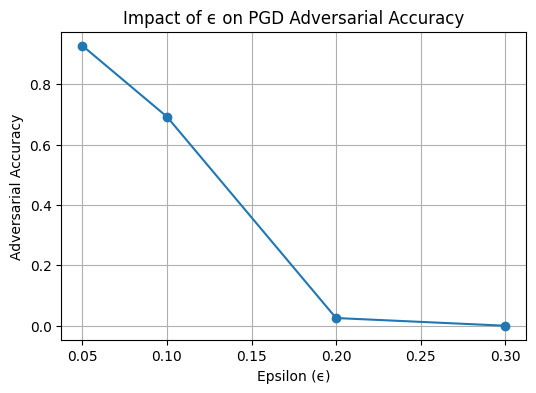

In [ ]:
# List of different epsilon values to test
epsilons = [0.05, 0.1, 0.2, 0.3]
pgd_accuracies = []

# Function to evaluate PGD accuracy for different epsilons
def evaluate_pgd_for_epsilons(model, test_loader, epsilons, device):
    results = []
    for eps in epsilons:
        # Initialize PGD attack with current epsilon
        pgd_attack = torchattacks.PGD(model, eps=eps, alpha=eps / 4, steps=40)

        # Evaluate model accuracy on PGD adversarial examples
        accuracy = evaluate_adversarial_accuracy(model, test_loader, pgd_attack, device)
        results.append((eps, accuracy))
        pgd_accuracies.append(accuracy)

        print(f"PGD Accuracy at ϵ={eps}: {accuracy * 100:.2f}%")

    return results

# Run the evaluation
pgd_results = evaluate_pgd_for_epsilons(model, test_loader, epsilons, device)

# Extract epsilon values and corresponding accuracies
eps_vals, acc_vals = zip(*pgd_results)

# Plot epsilon vs. accuracy
plt.figure(figsize=(6,4))
plt.plot(eps_vals, acc_vals, marker='o', linestyle='-')
plt.xlabel("Epsilon (ϵ)")
plt.ylabel("Adversarial Accuracy")
plt.title("Impact of ϵ on PGD Adversarial Accuracy")
plt.grid(True)
plt.show()

In [ ]:
print(pgd_accuracies)

[0.9278, 0.6925, 0.0255, 0.0]


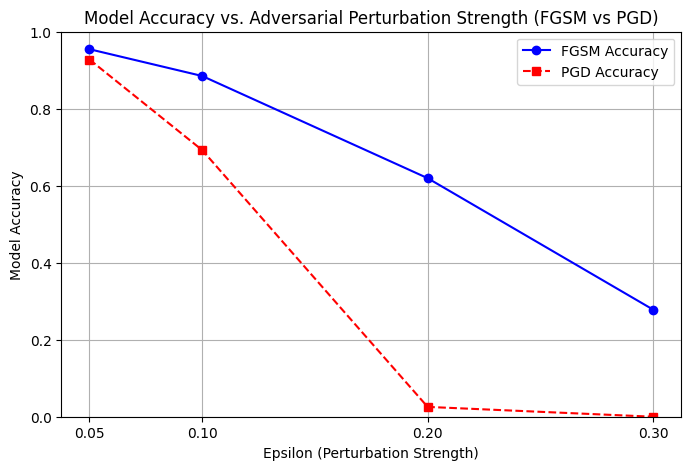

In [ ]:
#FGSM vs PGD
fgsm_accuracies = accuracies
# Plot the accuracy results for FGSM and PGD
plt.figure(figsize=(8, 5))
plt.plot(epsilons, fgsm_accuracies, marker='o', linestyle='-', color='b', label="FGSM Accuracy")
plt.plot(epsilons, pgd_accuracies, marker='s', linestyle='--', color='r', label="PGD Accuracy")
plt.xlabel("Epsilon (Perturbation Strength)")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy vs. Adversarial Perturbation Strength (FGSM vs PGD)")
plt.xticks(epsilons)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

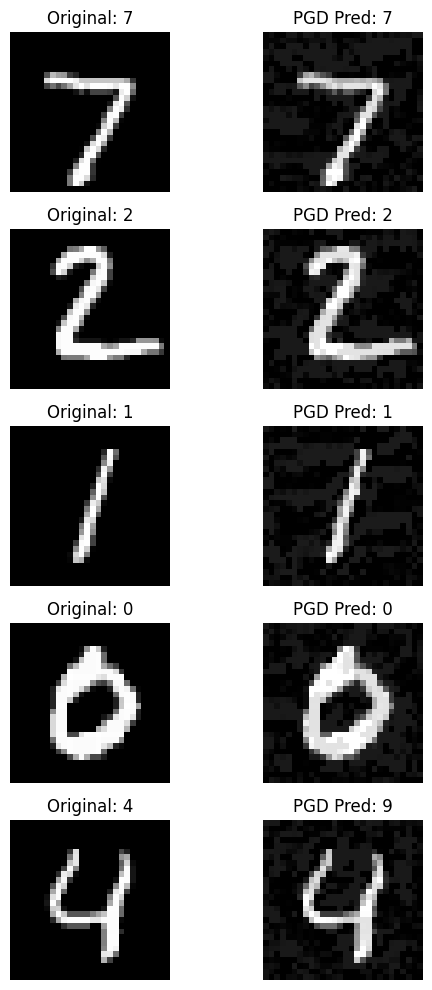

In [ ]:
# Select a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Generate adversarial examples using PGD
images.requires_grad = True  # Enable gradient tracking
adv_images_pgd = pgd_attack(images, labels)

# Get model predictions on PGD adversarial examples
model.eval()
outputs = model(adv_images_pgd)
_, predicted_labels = torch.max(outputs, 1)

# Convert images to CPU for visualization
images = images.cpu().detach()
adv_images_pgd = adv_images_pgd.cpu().detach()
labels = labels.cpu().detach()
predicted_labels = predicted_labels.cpu().detach()

# Display original vs PGD adversarial example with predictions
num_examples = 5  # Number of examples to display
fig, axes = plt.subplots(num_examples, 2, figsize=(6, 10))

for i in range(num_examples):
    orig_img = images[i].squeeze().numpy()
    adv_img = adv_images_pgd[i].squeeze().numpy()

    axes[i, 0].imshow(orig_img, cmap='gray')
    axes[i, 0].set_title(f"Original: {labels[i].item()}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(adv_img, cmap='gray')
    axes[i, 1].set_title(f"PGD Pred: {predicted_labels[i].item()}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

### Testing

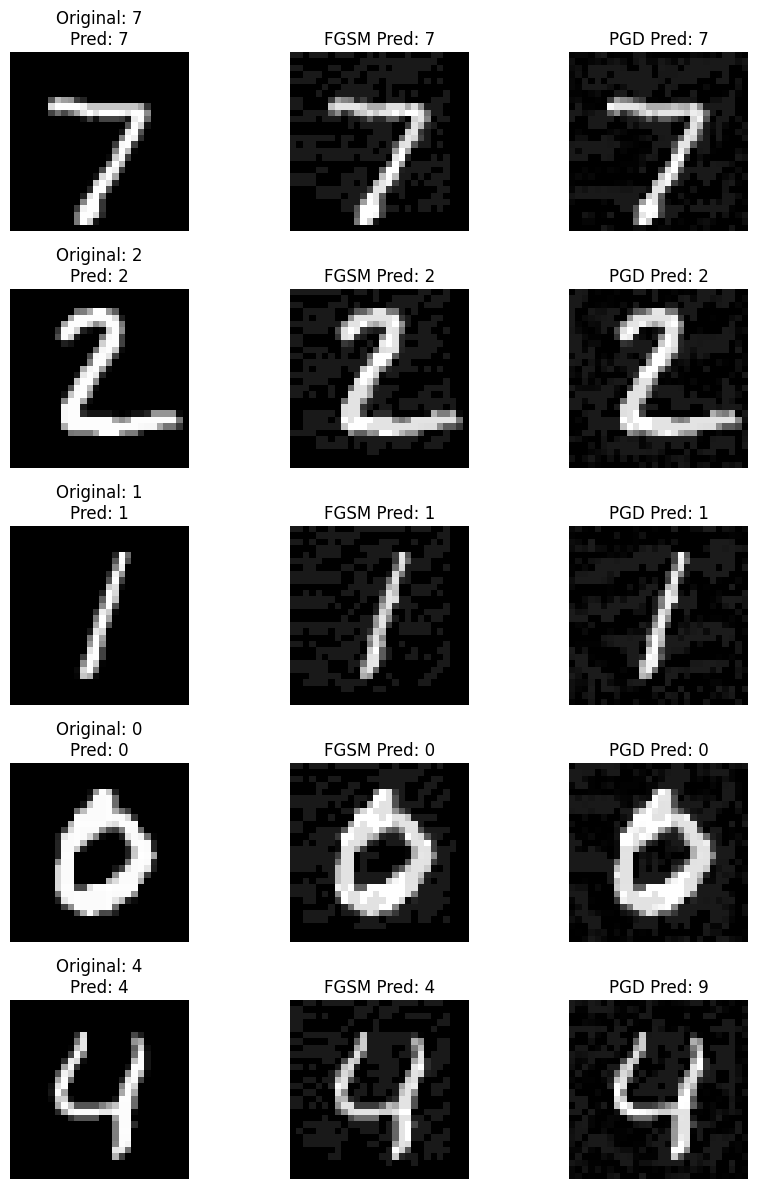

In [ ]:
# Testing for Epsilon .10
# Select a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Generate FGSM adversarial examples
images.requires_grad = True  # Enable gradient tracking
fgsm_attack = torchattacks.FGSM(model, eps=0.1)
adv_images_fgsm = fgsm_attack(images, labels)

# Generate PGD adversarial examples
pgd_attack = torchattacks.PGD(model, eps=0.1, alpha=0.01, steps=40)
adv_images_pgd = pgd_attack(images, labels)

# Get model predictions on clean, FGSM, and PGD adversarial examples
model.eval()
outputs_clean = model(images)
outputs_fgsm = model(adv_images_fgsm)
outputs_pgd = model(adv_images_pgd)

_, predicted_labels_clean = torch.max(outputs_clean, 1)
_, predicted_labels_fgsm = torch.max(outputs_fgsm, 1)
_, predicted_labels_pgd = torch.max(outputs_pgd, 1)

# Convert images to CPU for visualization
images = images.cpu().detach()
adv_images_fgsm = adv_images_fgsm.cpu().detach()
adv_images_pgd = adv_images_pgd.cpu().detach()
labels = labels.cpu().detach()
predicted_labels_clean = predicted_labels_clean.cpu().detach()
predicted_labels_fgsm = predicted_labels_fgsm.cpu().detach()
predicted_labels_pgd = predicted_labels_pgd.cpu().detach()

# Display original vs FGSM vs PGD adversarial examples with predictions
num_examples = 5  # Number of examples to display
fig, axes = plt.subplots(num_examples, 3, figsize=(9, 12))

for i in range(num_examples):
    orig_img = images[i].squeeze().numpy()
    fgsm_img = adv_images_fgsm[i].squeeze().numpy()
    pgd_img = adv_images_pgd[i].squeeze().numpy()

    axes[i, 0].imshow(orig_img, cmap='gray')
    axes[i, 0].set_title(f"Original: {labels[i].item()}\nPred: {predicted_labels_clean[i].item()}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(fgsm_img, cmap='gray')
    axes[i, 1].set_title(f"FGSM Pred: {predicted_labels_fgsm[i].item()}")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pgd_img, cmap='gray')
    axes[i, 2].set_title(f"PGD Pred: {predicted_labels_pgd[i].item()}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


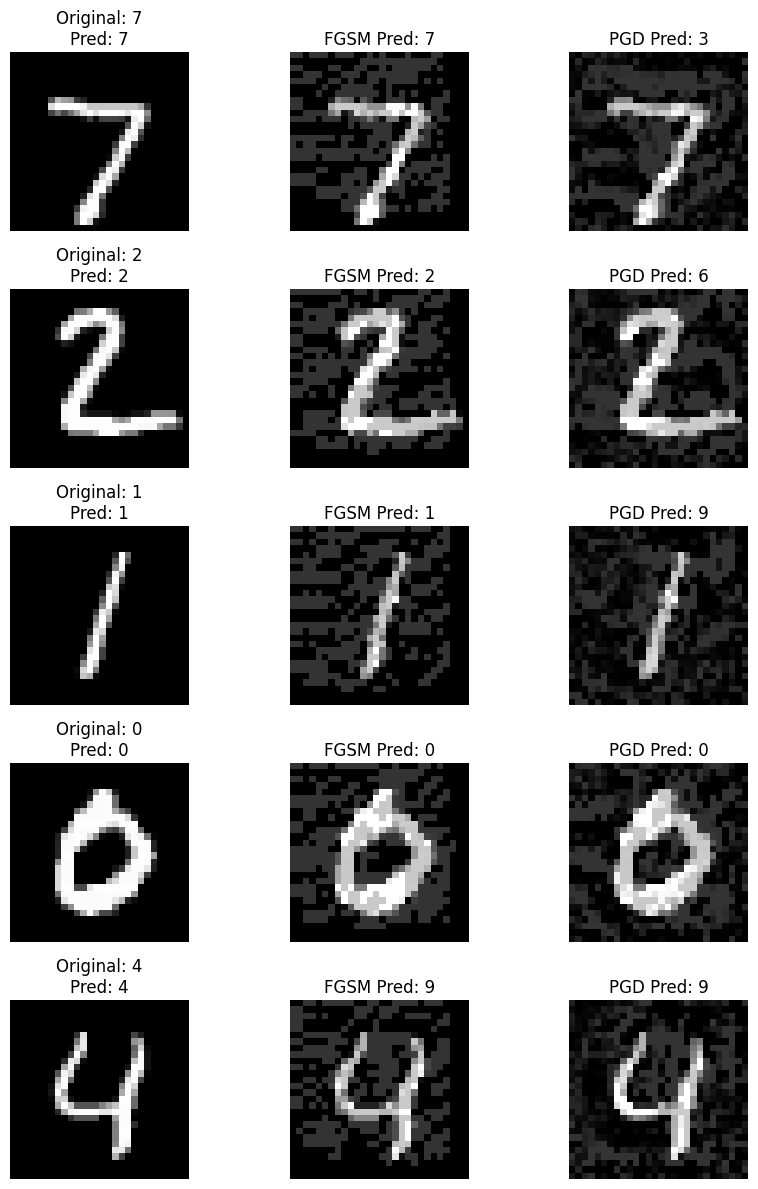

In [ ]:
# Testing for Epsilon .20
# Select a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Generate FGSM adversarial examples
images.requires_grad = True  # Enable gradient tracking
fgsm_attack = torchattacks.FGSM(model, eps=0.2)
adv_images_fgsm = fgsm_attack(images, labels)

# Generate PGD adversarial examples
pgd_attack = torchattacks.PGD(model, eps=0.2, alpha=0.01, steps=40)
adv_images_pgd = pgd_attack(images, labels)

# Get model predictions on clean, FGSM, and PGD adversarial examples
model.eval()
outputs_clean = model(images)
outputs_fgsm = model(adv_images_fgsm)
outputs_pgd = model(adv_images_pgd)

_, predicted_labels_clean = torch.max(outputs_clean, 1)
_, predicted_labels_fgsm = torch.max(outputs_fgsm, 1)
_, predicted_labels_pgd = torch.max(outputs_pgd, 1)

# Convert images to CPU for visualization
images = images.cpu().detach()
adv_images_fgsm = adv_images_fgsm.cpu().detach()
adv_images_pgd = adv_images_pgd.cpu().detach()
labels = labels.cpu().detach()
predicted_labels_clean = predicted_labels_clean.cpu().detach()
predicted_labels_fgsm = predicted_labels_fgsm.cpu().detach()
predicted_labels_pgd = predicted_labels_pgd.cpu().detach()

# Display original vs FGSM vs PGD adversarial examples with predictions
num_examples = 5  # Number of examples to display
fig, axes = plt.subplots(num_examples, 3, figsize=(9, 12))

for i in range(num_examples):
    orig_img = images[i].squeeze().numpy()
    fgsm_img = adv_images_fgsm[i].squeeze().numpy()
    pgd_img = adv_images_pgd[i].squeeze().numpy()

    axes[i, 0].imshow(orig_img, cmap='gray')
    axes[i, 0].set_title(f"Original: {labels[i].item()}\nPred: {predicted_labels_clean[i].item()}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(fgsm_img, cmap='gray')
    axes[i, 1].set_title(f"FGSM Pred: {predicted_labels_fgsm[i].item()}")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pgd_img, cmap='gray')
    axes[i, 2].set_title(f"PGD Pred: {predicted_labels_pgd[i].item()}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


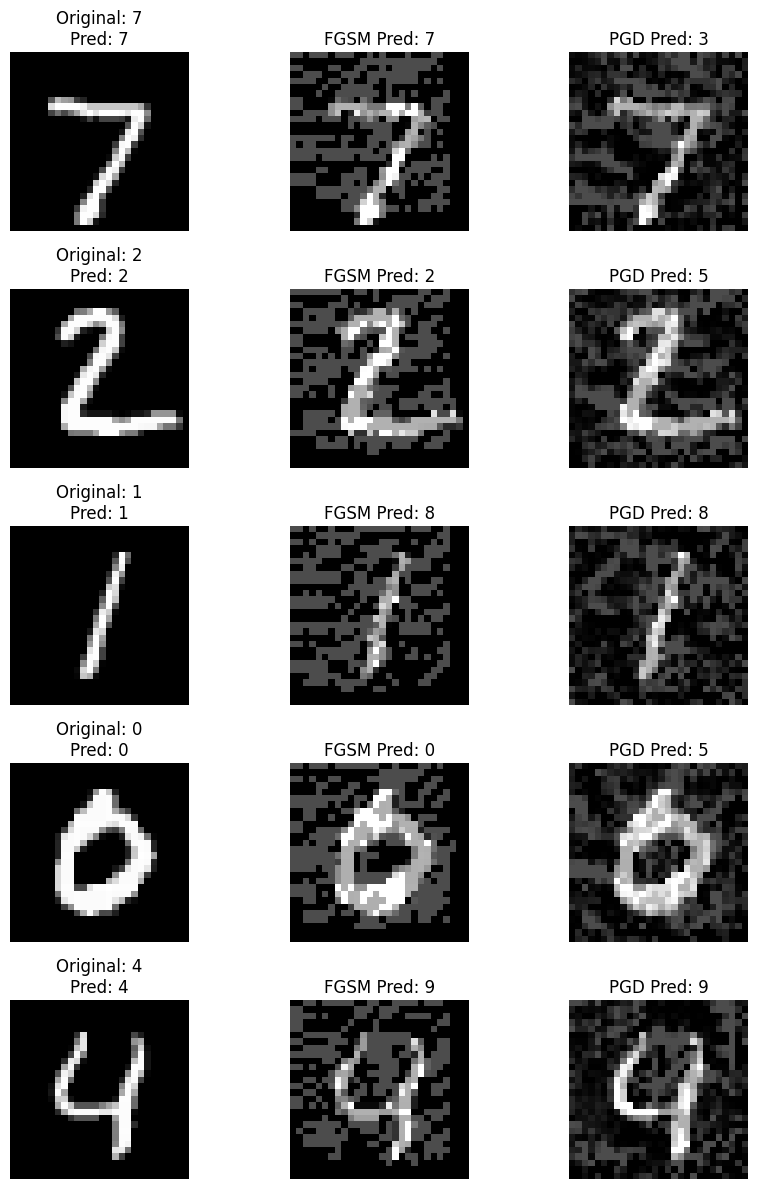

In [ ]:
# Testing for Epsilon .30
# Select a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Generate FGSM adversarial examples
images.requires_grad = True  # Enable gradient tracking
fgsm_attack = torchattacks.FGSM(model, eps=0.3)
adv_images_fgsm = fgsm_attack(images, labels)

# Generate PGD adversarial examples
pgd_attack = torchattacks.PGD(model, eps=0.3, alpha=0.01, steps=40)
adv_images_pgd = pgd_attack(images, labels)

# Get model predictions on clean, FGSM, and PGD adversarial examples
model.eval()
outputs_clean = model(images)
outputs_fgsm = model(adv_images_fgsm)
outputs_pgd = model(adv_images_pgd)

_, predicted_labels_clean = torch.max(outputs_clean, 1)
_, predicted_labels_fgsm = torch.max(outputs_fgsm, 1)
_, predicted_labels_pgd = torch.max(outputs_pgd, 1)

# Convert images to CPU for visualization
images = images.cpu().detach()
adv_images_fgsm = adv_images_fgsm.cpu().detach()
adv_images_pgd = adv_images_pgd.cpu().detach()
labels = labels.cpu().detach()
predicted_labels_clean = predicted_labels_clean.cpu().detach()
predicted_labels_fgsm = predicted_labels_fgsm.cpu().detach()
predicted_labels_pgd = predicted_labels_pgd.cpu().detach()

# Display original vs FGSM vs PGD adversarial examples with predictions
num_examples = 5  # Number of examples to display
fig, axes = plt.subplots(num_examples, 3, figsize=(9, 12))

for i in range(num_examples):
    orig_img = images[i].squeeze().numpy()
    fgsm_img = adv_images_fgsm[i].squeeze().numpy()
    pgd_img = adv_images_pgd[i].squeeze().numpy()

    axes[i, 0].imshow(orig_img, cmap='gray')
    axes[i, 0].set_title(f"Original: {labels[i].item()}\nPred: {predicted_labels_clean[i].item()}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(fgsm_img, cmap='gray')
    axes[i, 1].set_title(f"FGSM Pred: {predicted_labels_fgsm[i].item()}")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pgd_img, cmap='gray')
    axes[i, 2].set_title(f"PGD Pred: {predicted_labels_pgd[i].item()}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
